<a href="https://colab.research.google.com/github/ihatefish26/CodecTechnologies/blob/main/CREDIT_RISK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial dataset shape: (32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Missing values after imputation:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64
Balanced dataset shape: (49692, 16), (49692,)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:14:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


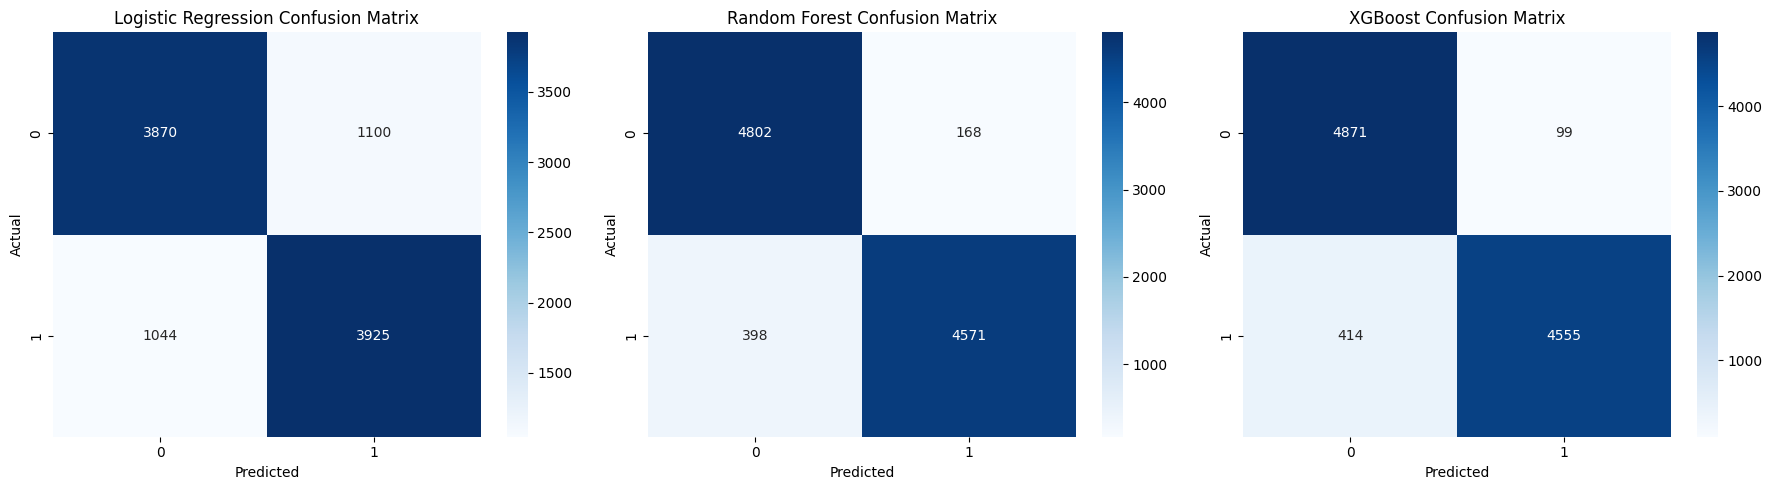

ROC AUC Score: 0.9833


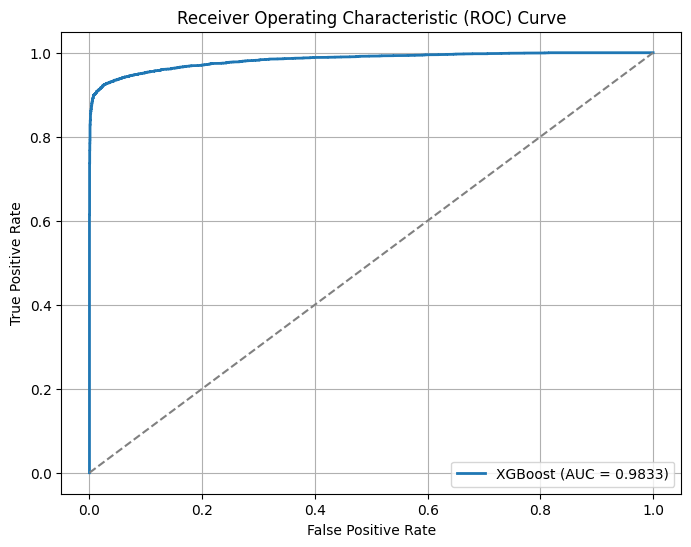

Sample thresholds and rates:
Threshold: inf | TPR: 0.000 | FPR: 0.000
Threshold: 1.000 | TPR: 0.075 | FPR: 0.000
Threshold: 1.000 | TPR: 0.150 | FPR: 0.000
Threshold: 0.999 | TPR: 0.303 | FPR: 0.000
Threshold: 0.726 | TPR: 0.883 | FPR: 0.005
Threshold: 0.463 | TPR: 0.924 | FPR: 0.026
Threshold: 0.336 | TPR: 0.942 | FPR: 0.063
Threshold: 0.232 | TPR: 0.959 | FPR: 0.127
Threshold: 0.156 | TPR: 0.974 | FPR: 0.216
Threshold: 0.084 | TPR: 0.988 | FPR: 0.380
Threshold: 0.001 | TPR: 1.000 | FPR: 0.953
📌 Loan Approval Decision: APPROVE ✅
Predicted Default Probability: 0.24


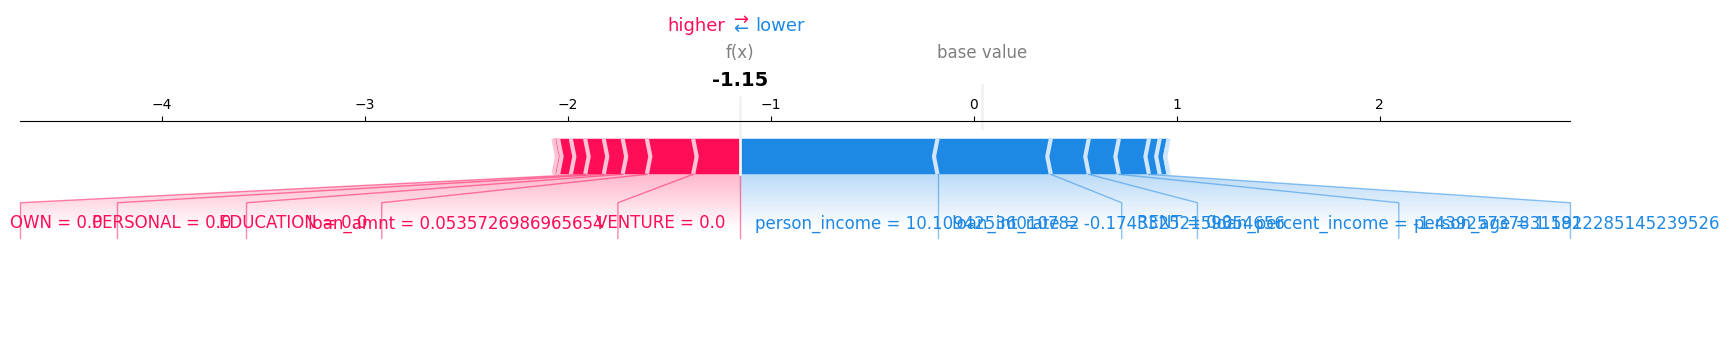

In [ ]:
# =============================================
# 📌 1. Install Required Libraries (Run once)
# =============================================
!pip install imbalanced-learn xgboost shap --quiet

# =============================================
# 📌 2. Import Libraries
# =============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE
import shap

# =============================================
# 📌 3. Load and Inspect Data
# =============================================
df = pd.read_csv("/credit_risk_dataset.csv")
print(f"Initial dataset shape: {df.shape}")
display(df.head())

# =============================================
# 📌 4. Data Cleaning & Outlier Removal
# =============================================
df = df[(df['person_age'] <= 70) & (df['person_emp_length'] <= 47)].reset_index(drop=True)

df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

print("Missing values after imputation:\n", df.isnull().sum())
df.drop(columns=['loan_grade'], inplace=True)

# =============================================
# 📌 5. Feature Engineering & Encoding
# =============================================
df['cb_person_default_on_file_binary'] = np.where(df['cb_person_default_on_file'] == 'Y', 1, 0)

home_ownership_dummies = pd.get_dummies(df['person_home_ownership'], drop_first=True, dtype=int)
loan_intent_dummies = pd.get_dummies(df['loan_intent'], drop_first=True, dtype=int)

# =============================================
# 📌 6. Feature Scaling
# =============================================
features_to_scale = df.drop(columns=['person_home_ownership', 'loan_intent',
                                    'loan_status', 'cb_person_default_on_file',
                                    'cb_person_default_on_file_binary'])

scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features_to_scale), columns=features_to_scale.columns)

final_df = pd.concat([scaled_features, home_ownership_dummies, loan_intent_dummies], axis=1)
final_df['cb_person_default_on_file'] = df['cb_person_default_on_file_binary']
final_df['loan_status'] = df['loan_status']

# =============================================
# 📌 7. Define Features & Target
# =============================================
X = final_df.drop(columns=['loan_status'])
y = final_df['loan_status']

# =============================================
# 📌 8. Handle Class Imbalance using SMOTE
# =============================================
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print(f"Balanced dataset shape: {X_balanced.shape}, {y_balanced.shape}")

# =============================================
# 📌 9. Train-Test Split
# =============================================
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced,
                                                    test_size=0.2, random_state=42, stratify=y_balanced)

# =============================================
# 📌 10. Model Training
# =============================================
logit = LogisticRegression(max_iter=500, random_state=42)
logit.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

xgb = XGBClassifier(tree_method="hist", use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# =============================================
# 📌 11. Model Evaluation: Confusion Matrices
# =============================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = {'Logistic Regression': logit, 'Random Forest': rf, 'XGBoost': xgb}

for ax, (name, model) in zip(axes, models.items()):
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# =============================================
# 📌 12. ROC Curve & AUC Plot Function
# =============================================
def plot_roc_auc(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)

    print(f"ROC AUC Score: {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Sample thresholds and rates:")
    step = max(1, len(thresholds) // 10)
    for i in range(0, len(thresholds), step):
        print(f"Threshold: {thresholds[i]:.3f} | TPR: {tpr[i]:.3f} | FPR: {fpr[i]:.3f}")

# Call this function to visualize ROC curve and select threshold
plot_roc_auc(xgb, X_test, y_test)

# =============================================
# 📌 13. SHAP Explanation Setup for XGBoost
# =============================================
explainer = shap.TreeExplainer(xgb)

# =============================================
# 📌 14. Applicant Evaluation Function
# =============================================
def evaluate_applicant(applicant_data, model, explainer, scaler, threshold=0.5):
    applicant_df = pd.DataFrame([applicant_data])

    if 'loan_percent_income' not in applicant_df.columns:
        applicant_df['loan_percent_income'] = applicant_df['loan_amnt'] / applicant_df['person_income']

    for col in features_to_scale.columns:
        if col not in applicant_df.columns:
            applicant_df[col] = 0

    scaled_applicant = pd.DataFrame(scaler.transform(applicant_df[features_to_scale.columns]),
                                    columns=features_to_scale.columns)

    home_df = pd.get_dummies(applicant_df['person_home_ownership'], drop_first=True).astype(int)
    loan_df = pd.get_dummies(applicant_df['loan_intent'], drop_first=True).astype(int)

    for col in home_ownership_dummies.columns:
        if col not in home_df.columns:
            home_df[col] = 0
    for col in loan_intent_dummies.columns:
        if col not in loan_df.columns:
            loan_df[col] = 0

    final_applicant = pd.concat([scaled_applicant, home_df, loan_df], axis=1)
    final_applicant['cb_person_default_on_file'] = np.where(applicant_df['cb_person_default_on_file'] == 'Y', 1, 0)

    # Ensure columns order matches training
    final_applicant = final_applicant[X.columns]

    prob_default = model.predict_proba(final_applicant)[:, 1][0]
    decision = "APPROVE ✅" if prob_default < threshold else "REJECT ❌"

    print(f"📌 Loan Approval Decision: {decision}")
    print(f"Predicted Default Probability: {prob_default:.2f}")

    shap_values = explainer.shap_values(final_applicant)
    shap.force_plot(explainer.expected_value, shap_values, final_applicant, matplotlib=True)

# =============================================
# 📌 15. Evaluate New Applicant
# =============================================
new_applicant = {
    'person_age': 35,
    'person_income': 600000,
    'person_emp_length': 10,
    'loan_amnt': 10000,
    'loan_int_rate': 10.5,
    'person_home_ownership': 'MORTGAGE',
    'loan_intent': 'EDUCATION',
    'cb_person_default_on_file': 'N',
    'cb_person_cred_hist_length': 5
}

# Example usage: after viewing ROC curve, choose threshold accordingly (default 0.5)
evaluate_applicant(new_applicant, xgb, explainer, scaler, threshold=0.5)


Business Insights:

**Model Performance:** XGBoost appears to be a strong performer based on the provided confusion matrix and ROC AUC score (0.9833), suggesting it can effectively differentiate between good and bad loan applications.
**Class Imbalance Handling:** The use of SMOTE highlights the importance of addressing imbalanced datasets in credit risk modeling. Ignoring imbalance can lead to models that are biased towards the majority class (non-defaults), resulting in poor performance in identifying actual defaults.
**Feature Importance and Explainability (SHAP):** The SHAP force plot for the new applicant provides valuable insights into why the model made a specific prediction. It shows which features pushed the prediction towards approval (blue) or rejection (red) and by how much. This explainability is crucial for:
**Transparency:** Understanding the reasons behind lending decisions.
Risk Mitigation: Identifying key risk factors for individual applicants.
Regulatory Compliance: Providing explanations for automated lending decisions.
**Improving Lending Policies:** Using feature importance to refine lending criteria.
**Threshold Selection:** The ROC curve and the table of thresholds, TPR, and FPR are vital for selecting an appropriate threshold for loan approval. The choice of threshold depends on the business's risk appetite. A lower threshold will result in more approvals but also more false positives (approving loans that default), while a higher threshold will result in fewer approvals but also fewer false negatives (rejecting loans that would not default).
**Automated Lending:** The evaluate_applicant function demonstrates how the trained model can be used to automate the loan approval process, providing a quick decision and an explanation for it.